In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3, style="whitegrid")

## Carregando os dados

In [5]:
df = pd.read_json('data/BASE A/premium_students.json')
df['SubscriptionDate'] = pd.to_datetime(df['SubscriptionDate'])
df['RegisteredDate'] = pd.to_datetime(df['RegisteredDate'])

df['register_day'] = df.RegisteredDate.dt.day

df['sub_year'] = df.SubscriptionDate.dt.year
df['sub_month'] = df.SubscriptionDate.dt.month
df['sub_year-month'] = df['sub_year'].astype(str) + '-' + df['sub_month'].astype(str)

df.head()

,StudentId,RegisteredDate,SubscriptionDate,register_day,sub_year,sub_month,sub_year-month
0,98723802,2017-11-01 00:06:09.988381,2017-11-01 01:20:11.000000,1,2017,11,2017-11
1,86905029,2017-11-01 00:19:31.215160,2017-11-17 21:58:57.163663,1,2017,11,2017-11
2,40935842,2017-11-01 00:23:43.138459,2017-11-01 01:26:17.114303,1,2017,11,2017-11
3,83184096,2017-11-01 00:27:33.721328,2018-05-18 14:08:42.000000,1,2018,5,2018-5
4,12771137,2017-11-01 00:32:57.191732,2017-11-01 00:59:44.849137,1,2017,11,2017-11


## Gráfico das datas de registro
Somente para verificar se não há algum comportamento muito específico ao longo do mês. Acredito que a tendência ao longo do mês de novembro, conforme o final do ano letivo se aproxima, seja de redução no número de registros, como observado.

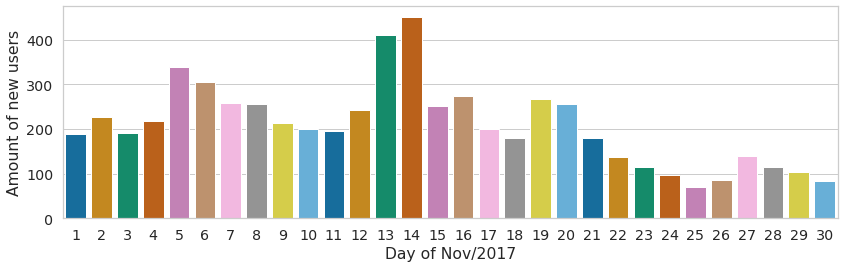

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.barplot(x='register_day', y='RegisteredDate', 
            data=df.groupby('register_day', sort=False).count()['RegisteredDate'].reset_index(),
            palette='colorblind', ax=ax)
ax.set_ylabel('Amount of new users')
ax.set_xlabel('Day of Nov/2017')
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
fig.tight_layout()
plt.savefig('figures/question_1/new_registers.eps', format='eps')

## Gráfico das datas de assinatura
Pelo gráfico, é possível observar três comportamentos distintos: o primeiro com assinaturas ainda em novembro e dezembro de 2017, o segundo momento em janeiro e fevereiro com uma queda no número de assinaturas e coincidindo com o período de férias escolares; e um terceiro momento com aumento no número de assinaturas de março em diante conforme o ano letivo recomeça (os dados de junho de 2018 parecem incompletos nesse conjunto de dados).

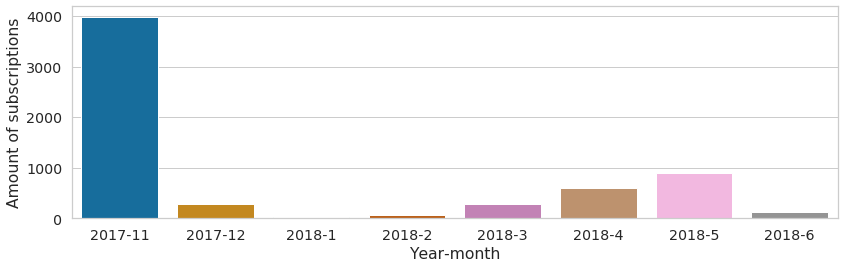

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.barplot(x='sub_year-month', y='SubscriptionDate', 
            data=df.sort_values('SubscriptionDate').groupby('sub_year-month', 
                                                            sort=False).count()['SubscriptionDate'].reset_index(),
            palette='colorblind', ax=ax)
ax.set_ylabel('Amount of subscriptions')
ax.set_xlabel('Year-month')
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
fig.tight_layout()
plt.savefig('figures/question_1/new_subscribers.eps', format='eps')

#### Mais de 68% dos estudantes virou Premium ainda em 2017

In [16]:
100 * len(df[df['SubscriptionDate'] < '2018-01-01']) / len(df)

68.21086261980831

### Limitando a análise
A partir dessas análises, o terceiro momento com aumento das assinaturas parece estar intimamente relacionado à época do ano e não à forma como o usuário é introduzido aos planos e vantagens após o registro. Portanto, para esta análise, só irei considerar os alunos que se registraram até o fim de 2017.

In [27]:
df = df[df['SubscriptionDate'] < '2018-01-01']

### Calculando a quantidade de dias do registro até a assinatura
É possível observar que cerca de 75% dos alunos que criaram a conta em Nov/17 e assinaram até o final do ano, fizeram a assinaturam dentro de 2 dias.

In [29]:
date_diff = df['SubscriptionDate'] - df['RegisteredDate']
days = date_diff.dt.total_seconds() / (3600 * 24) # Convert to days
days.describe()

count    4270.000000
mean        3.036021
std         6.635352
min         0.000700
25%         0.086457
50%         0.111286
75%         2.020434
max        45.686709
dtype: float64

### Analisando em ranges específicos
A partir dessa análise, dos alunos que criaram a conta em Nov/17 e assinaram até o final do ano, cerca de 70% viraram Premium ainda no primeiro dia. Passado esse primeiro dia, cerca de 15% dos usuários decidiram por assinar antes de uma semana de uso. 

A partir desses dados, parece que o estudante já se registra na plataforma com uma necessidade a ser sanada, como acesso a algum livro ou material, e, por conta do *Content Restriction*, vê o Premium como uma oportunidade viável de ter acesso a todo esse material em um só lugar. Especialmnente para o caso de livros, que podem ter preços bem elevados e o preço da assinatura acaba valendo mais a pena.

In [79]:
ranges = [(0, 1), (1, 7), (7, 14), (14, 30), (30, None)]
total = float(len(days))
for days_range in ranges:
    min_days = days_range[0]
    max_days = days_range[1] if days_range[1] is not None else int(np.ceil(days.max()))
    prob = ((days >= min_days) & (days < max_days)).sum() / total
    print(f'From {min_days} to {max_days} days: {round(prob * 100, 2)}% students')

From 0 to 1 days: 70.21% students
From 1 to 7 days: 14.89% students
From 7 to 14 days: 7.7% students
From 14 to 30 days: 5.76% students
From 30 to 46 days: 1.43% students


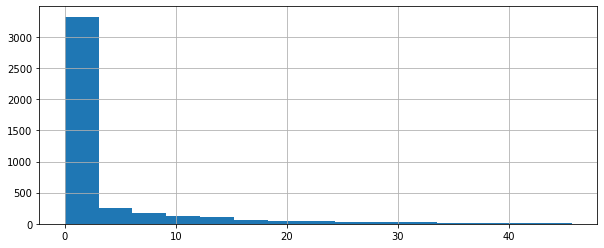

In [76]:
days.hist(grid=True, bins=15, figsize=(10,4))